In [1]:
import os
import numpy as np
import time
import scipy.stats as stats
from scipy.special import factorial
import csv
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.stats.multitest as sm
from fisher import pvalue_npy
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from sklearn.metrics import average_precision_score
from mpl_toolkits import mplot3d

# Import data

In [2]:
imulabel = pd.read_csv('./oclabel/immport.mRNA0728.txt').values
imulabel = np.squeeze(imulabel)
print(len(imulabel))

254


In [3]:
# imulabel = pd.read_csv('../data/immune_related_genes.csv')['Gene Name'].values

df1 = pd.read_csv('./ocRMA/exp.mRNA.AgilentG4502A_07_2.txt',sep = "\t", index_col=0,header = 0)
df2 = pd.read_csv('./ocRMA/exp.mRNA.HT_HG-U133A.txt',sep = "\t", index_col=0,header = 0)
df3 = pd.read_csv('./ocRMA/exp.mRNA.GSE6008.RMA.txt',sep = "\t", index_col=0,header = 0)
df4 = pd.read_csv('./ocRMA/exp.mRNA.GSE18520.RMA.txt',sep = "\t", index_col=0,header = 0)
df5 = pd.read_csv('./ocRMA/exp.mRNA.GSE40595.RMA.txt',sep = "\t", index_col=0,header = 0)
df6 = pd.read_csv('./ocRMA/mRNA.validation.txt',sep = "\t", index_col=0,header = 0)
df6 = df6.drop(df6.columns[range(8,16)],axis=1)

# df7 = pd.read_csv('./ocRMA/combat.ocdata.txt',sep="\t",index_col=0,header=0)

print(df1.shape)
print(df2.shape)
print (df3.shape)
print (df4.shape)
print (df5.shape)
print (df6.shape)
# print (df7.shape)

(17814, 37)
(12042, 593)
(12548, 45)
(21655, 63)
(21655, 38)
(17995, 16)


In [4]:
imuidx = pd.Index(imulabel)
comidx = df1.index.join(
    df2.index.join(
        df3.index.join(
            df4.index.join(
                df5.index.join(
                    df6.index.join(imuidx,how='inner'),how='inner')
            ,how='inner')
        ,how='inner')
    ,how='inner')
,how='inner')

In [5]:
len(comidx)

219

In [6]:
df1 = df1.loc[comidx]
df2 = df2.loc[comidx]
df3 = df3.loc[comidx]
df4 = df4.loc[comidx]
df5 = df5.loc[comidx]
df6 = df6.loc[comidx]
# df7 = df7.loc[comidx]
    
print(df1.shape)
print(df2.shape)
print (df3.shape)
print (df4.shape)
print (df5.shape)
print (df6.shape)
# print (df7.shape)

(219, 37)
(219, 593)
(219, 45)
(219, 63)
(219, 38)
(219, 16)


# Import label

In [7]:
lab1 = np.genfromtxt('./oclabel/AgilentG4502A_07_2.label.txt',dtype="U16,u1")['f1']
lab2 = np.genfromtxt('./oclabel/HT_HG-U133A.label.txt',dtype="U16,u1")['f1']
lab3 = np.genfromtxt('./oclabel/GSE6008.label.txt',dtype="U16,U16,u1")['f2']
lab4 = np.genfromtxt('./oclabel/GSE18520.label.txt',dtype="U16,U16,U16,u1,u1")['f4']
lab5 = np.genfromtxt('./oclabel/GSE40595.label.txt',dtype="U16,U16,U16,U16,U16,U16,U16,u1")['f7']
lab6 = np.genfromtxt('./oclabel/mRNA.label.txt',dtype="U16,u1")['f1']
# lab7 = np.genfromtxt('./oclabel/combat.label.txt',dtype="U16,u1")['f1']
lab6 = np.delete(lab6,range(8,16))

# Set Training data, Validation data and Testing data

In [8]:
# trainname = "RMA_testonMAS"
diff = 0.5

x_train = np.concatenate((df2.to_numpy(),df4.to_numpy(),df6.to_numpy()),axis=1).T
y_train = np.concatenate((lab2,lab4,lab6))

# x_train = df7.to_numpy().T
# y_train = lab7

x_train1 = df2.to_numpy().T
y_train1 = lab2
x_train2 = df4.to_numpy().T
y_train2 = lab4

x_test1 = df3.to_numpy().T
x_test2 = df5.to_numpy().T
x_test3 = df1.to_numpy().T
x_test4 = df6.to_numpy().T
y_test1 = lab3
y_test2 = lab5
y_test3 = lab1
y_test4 = lab6

length = len(x_train[0,:])
n_sm = len(x_train[:,0])
print ("Shape of training data: ",x_train.shape)
print ("length of data = ", length)
print ("number of samples = ", n_sm)

Shape of training data:  (672, 219)
length of data =  219
number of samples =  672


# Substract and obtain relative rank of every pairs

In [9]:
# create a n_sm x length x length metrix that restores the subtraction between two genes, 30 represents sample size
t1 = time.time()
result1 = np.zeros([length,length,n_sm],dtype=np.bool)
result1_ = np.zeros([length,length,n_sm],dtype=np.bool)
for i in range(0,n_sm):
    time_l = time.time()
    x = np.tile(x_train[i,:], (length,1))
    sub = x - x.T
    
    result1[:,:,i] = (sub > diff)
    result1_[:,:,i] = (sub < -diff)
    
    print('loop {:d} : {:5f}'.format(i, time.time() - time_l))

print('shape of result1: ', np.shape(result1))
print('shape of result1_: ', np.shape(result1_))
print('total time: ', time.time() - t1)

loop 0 : 0.004983
loop 1 : 0.001307
loop 2 : 0.000714
loop 3 : 0.000736
loop 4 : 0.000627
loop 5 : 0.000623
loop 6 : 0.000679
loop 7 : 0.000623
loop 8 : 0.000664
loop 9 : 0.000680
loop 10 : 0.000624
loop 11 : 0.000620
loop 12 : 0.000668
loop 13 : 0.000622
loop 14 : 0.000607
loop 15 : 0.000704
loop 16 : 0.000787
loop 17 : 0.000659
loop 18 : 0.000604
loop 19 : 0.000597
loop 20 : 0.000646
loop 21 : 0.000584
loop 22 : 0.000592
loop 23 : 0.000639
loop 24 : 0.000585
loop 25 : 0.000591
loop 26 : 0.000597
loop 27 : 0.000659
loop 28 : 0.000648
loop 29 : 0.000639
loop 30 : 0.000590
loop 31 : 0.000508
loop 32 : 0.000491
loop 33 : 0.000487
loop 34 : 0.000490
loop 35 : 0.000481
loop 36 : 0.000489
loop 37 : 0.000481
loop 38 : 0.000488
loop 39 : 0.000478
loop 40 : 0.000519
loop 41 : 0.000478
loop 42 : 0.000515
loop 43 : 0.000479
loop 44 : 0.000489
loop 45 : 0.000478
loop 46 : 0.000489
loop 47 : 0.000478
loop 48 : 0.000735
loop 49 : 0.000598
loop 50 : 0.000496
loop 51 : 0.000495
loop 52 : 0.000482
loo

loop 557 : 0.000902
loop 558 : 0.000637
loop 559 : 0.000580
loop 560 : 0.000890
loop 561 : 0.000603
loop 562 : 0.000531
loop 563 : 0.000481
loop 564 : 0.000497
loop 565 : 0.000475
loop 566 : 0.000493
loop 567 : 0.000526
loop 568 : 0.000486
loop 569 : 0.000516
loop 570 : 0.000436
loop 571 : 0.000498
loop 572 : 0.000486
loop 573 : 0.000510
loop 574 : 0.000478
loop 575 : 0.000505
loop 576 : 0.000477
loop 577 : 0.000488
loop 578 : 0.000481
loop 579 : 0.000485
loop 580 : 0.000481
loop 581 : 0.000526
loop 582 : 0.000570
loop 583 : 0.000498
loop 584 : 0.000474
loop 585 : 0.000477
loop 586 : 0.000469
loop 587 : 0.000479
loop 588 : 0.000468
loop 589 : 0.000473
loop 590 : 0.000467
loop 591 : 0.000475
loop 592 : 0.000715
loop 593 : 0.000482
loop 594 : 0.000491
loop 595 : 0.000416
loop 596 : 0.000487
loop 597 : 0.000476
loop 598 : 0.000488
loop 599 : 0.000477
loop 600 : 0.000487
loop 601 : 0.000476
loop 602 : 0.000502
loop 603 : 0.000477
loop 604 : 0.000485
loop 605 : 0.000506
loop 606 : 0.000499


# Figure out the number of greater or lower rank pairs among all the samples

In [10]:
# prepare data for fisher exact test, a,c is greater, b,d is smaller
# Control
con_label = 1 - y_train
a = np.sum(result1 * con_label, axis = 2)
b = np.sum(result1_* con_label, axis = 2)

# Case
c = np.sum(result1 * y_train, axis = 2)
d = np.sum(result1_* y_train, axis = 2)

print ('shape of a', np.shape(a))

shape of a (219, 219)


# Gene pair to gene

In [11]:
def pair2gene(index):
    result = index.reshape((-1,1))
    result = np.squeeze(result)
    result = np.unique(result)
    return result

## Use reversal percentage to figure out pairs

In [12]:
rev_list = np.arange(0.9, 0.8, -0.01)
rev_list = [0.9,0.88,0.87,0.86,0.84,0.83,0.82,0.81,0.80,0.79,0.78,0.77,0.76]

num_disease = np.sum(y_train)
num_control = len(y_train) - num_disease

print ("num of case: ", num_disease)
print ("num of control: ", num_control)

for rev in rev_list:
    at = ((a.astype(float)/num_control) >= rev)
    dt = ((d.astype(float)/num_disease) >= rev)

    index0, index1 = np.where(at * dt>0)
    
    for i in range(0,len(index0)):
        if index0[i] > index1[i]:
            index0[i],index1[i] = index1[i],index0[i]   
    print ("reversal percentage = ", rev)
    print ("number of pairs = ", len(index0))
    print ("number of genes = ", len(np.union1d(index0,index1)))
    
index = np.stack((index0, index1))

index_ = index.T
print("a ,b ,c ,d ")
for i,j in index_ :
    print(a[i,j], b[i,j], c[i,j], d[i,j])

num of case:  646
num of control:  26.0
reversal percentage =  0.9
number of pairs =  6
number of genes =  7
reversal percentage =  0.88
number of pairs =  12
number of genes =  13
reversal percentage =  0.87
number of pairs =  13
number of genes =  14
reversal percentage =  0.86
number of pairs =  14
number of genes =  16
reversal percentage =  0.84
number of pairs =  28
number of genes =  31
reversal percentage =  0.83
number of pairs =  28
number of genes =  31
reversal percentage =  0.82
number of pairs =  33
number of genes =  35
reversal percentage =  0.81
number of pairs =  36
number of genes =  37
reversal percentage =  0.8
number of pairs =  64
number of genes =  57
reversal percentage =  0.79
number of pairs =  65
number of genes =  58
reversal percentage =  0.78
number of pairs =  72
number of genes =  64
reversal percentage =  0.77
number of pairs =  75
number of genes =  65
reversal percentage =  0.76
number of pairs =  110
number of genes =  83
a ,b ,c ,d 
22 1 27 523
21 

In [13]:
def rev_index(a,b,c,d,rev_threshold):
    num_disease = np.sum(y_train)
    num_control = len(y_train) - num_disease

    rev = rev_threshold
    at = ((a.astype(float)/num_control) >= rev)
    dt = ((d.astype(float)/num_disease) >= rev)

    index0, index1 = np.where(at * dt>0)
    for i in range(0,len(index0)):
        if index0[i] > index1[i]:
            index0[i],index1[i] = index1[i],index0[i]
    print ("reversal percentage = ", rev)
    print ("number of pairs = ", len(index0))
    index = np.stack((index0, index1))
    return index,len(index0)

## Use fisher exact test to find out reversal pairs

In [14]:
a_ = a.reshape((-1,1))
a_ = np.squeeze(a_)
a_ = a_.astype(np.uint)
b_ = b.reshape((-1,1))
b_ = np.squeeze(b_)
b_ = b_.astype(np.uint)
c_ = c.reshape((-1,1))
c_ = np.squeeze(c_)
c_ = c_.astype(np.uint)
d_ = d.reshape((-1,1))
d_ = np.squeeze(d_)
d_ = d_.astype(np.uint)

# fisher exact test
_, _, twosided = pvalue_npy(a_, b_, c_, d_)

# fdr
rejected, pvalue_fdr = sm.fdrcorrection(twosided, method='indep', is_sorted=False)
pvalue_fdr2 = pvalue_fdr.reshape((length,length))

rejected, pvalue_Bonf, alphacSidak, alphacBonf = sm.multipletests(twosided, alpha=0.05, method='bonferroni', 
                                                                  is_sorted=False, returnsorted=False)
pvalue_Bonf2 = pvalue_Bonf.reshape((length,length))
    
pvalue2 = twosided.reshape((length,length))

In [15]:
def fisher_index(pvalue_Bonf2,threshold):
    # find indices of pvalue < fdr_threshold
    length = len(pvalue_Bonf2[0,:])
    # add 1 in triangle matrix to remove duplicated index
#     pvalue_matrix = pvalue_Bonf2 + np.triu(np.ones([length,length]))
    pvalue_matrix = pvalue_Bonf2 + np.triu(np.ones([length,length])*10)
    j,k = np.where(pvalue_matrix < threshold)
    result3 = np.array([j,k],dtype = np.uint16)
    result4 = []
    for m,n in result3.T:
        if a[m,n]==num_control:
            result4.append([m,n])
    print ("pvalue_Bonf_threshold = ", threshold)
    print ("number of pairs = ",len(result4))
    print ("number of genes = ", len(np.unique(result4)))
    return np.array(result4,dtype = np.uint16).T,len(result4)

In [19]:
# length = len(pvalue_Bonf2[0,:])
    # add 1 in triangle matrix to remove duplicated index
#     pvalue_matrix = pvalue_Bonf2 + np.triu(np.ones([length,length]))
j,k = np.where(pvalue_Bonf2
               < 1e-3)
k

array([  6,  14,  16, ..., 195, 207, 208])

In [54]:
# thresholds = [5e-2,1e-2,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-20,1e-22]
thresholds = [1e-2,1e-3,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17,1e-20]
for threshold in thresholds:
    rev_rlt,_ = fisher_index(pvalue_fdr2,threshold)
    index_ = rev_rlt.T
#     print ("a ,b ,c ,d ")
#     for i,j in index_ :
#         print (a[i,j], b[i,j], c[i,j], d[i,j])

pvalue_Bonf_threshold =  0.01
number of pairs =  70
number of genes =  60
pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52
pvalue_Bonf_threshold =  1e-06
number of pairs =  30
number of genes =  36
pvalue_Bonf_threshold =  1e-07
number of pairs =  24
number of genes =  31
pvalue_Bonf_threshold =  1e-08
number of pairs =  17
number of genes =  21
pvalue_Bonf_threshold =  1e-09
number of pairs =  16
number of genes =  20
pvalue_Bonf_threshold =  1e-10
number of pairs =  14
number of genes =  18
pvalue_Bonf_threshold =  1e-11
number of pairs =  13
number of genes =  16
pvalue_Bonf_threshold =  1e-12
number of pairs =  10
number of genes =  13
pvalue_Bonf_threshold =  1e-13
number of pairs =  7
number of genes =  9
pvalue_Bonf_threshold =  1e-14
number of pairs =  6
number of genes =  8
pvalue_Bonf_threshold =  1e-15
number of pairs =  5
number of genes =  7
pvalue_Bonf_threshold =  1e-16
number of pairs =  3
number of genes =  5
pvalue_Bonf_threshold =  1e-17
num

## Convert relative rank into 1 and -1

In [55]:
def pairconvert(data, index):
    sub1 = data[:,index[0,:]] - data[:,index[1,:]] > diff
    sub2 = -1*(data[:,index[0,:]] - data[:,index[1,:]] < -diff)
    sub = sub1+sub2
    return sub

# Data extraction

In [56]:
def extract(data,index,typ):
    if typ == 'rank':
        extract_data = pairconvert(data,index)
    if typ == 'value':
        value_index = pair2gene(index)
        extract_data = data[:,value_index]
    return extract_data

In [57]:
def extract2(data, index):
    sub = data[:,index[0,:]] - data[:,index[1,:]] > 0    
    sub = sub*2-1
    return sub

# Rank testing

In [58]:
def test_rank(data,label,index):
    # for pair, the value of pairconvert is 1 for disease, -1 for health
    rankdata = pairconvert(data,index)
    
    num = len(index[0,:])
    tag = []

    for i in range(0,num):
        tag.append(a[index[0,i],index[1,i]] > b[index[0,i],index[1,i]])
    
    tag = np.array(tag)
    tag = tag*2-1
    
    # convert into 1 and 0
    rankdata = rankdata*tag > 0

    # Use those lasso coefficient is not zero
#     filt = clf.coef_!=0
#     rank = rankdata * filt
#     print "number of pair whose coefficient is not zero: ", np.sum(filt)
    # sumup, then the value represent the percentage of reversal pairs
#     rankpredt_less = np.squeeze(np.sum(rank, axis = 1))/10.0

#     print "Rank less ROC AUC: ", metrics.roc_auc_score(label, rankpredt_less)
#     plot_roc(label,rankpredt)

    rankpredt_more = np.squeeze(np.sum(rankdata, axis = 1))/3.0
#     print "Rank more ROC AUC: ", metrics.roc_auc_score(label, rankpredt_more)
#     plot_roc(label,rankpredt_more)
    return rankpredt_more

# Forward Selction

pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52
best combination (AUC: 1.000): (1, 17, 42)

all subsets:
 {1: {'feature_idx': (42,), 'cv_scores': array([0.96153846, 0.97286822, 0.96124031, 0.9379845 , 0.96124031]), 'avg_score': 0.9589743589743589, 'feature_names': ('42',)}, 2: {'feature_idx': (17, 42), 'cv_scores': array([0.99230769, 0.99224806, 0.99612403, 0.99224806, 0.99224806]), 'avg_score': 0.9930351818723911, 'feature_names': ('17', '42')}, 3: {'feature_idx': (1, 17, 42), 'cv_scores': array([1., 1., 1., 1., 1.]), 'avg_score': 1.0, 'feature_names': ('1', '17', '42')}, 4: {'feature_idx': (0, 1, 17, 42), 'cv_scores': array([1., 1., 1., 1., 1.]), 'avg_score': 1.0, 'feature_names': ('0', '1', '17', '42')}, 5: {'feature_idx': (0, 1, 2, 17, 42), 'cv_scores': array([1., 1., 1., 1., 1.]), 'avg_score': 1.0, 'feature_names': ('0', '1', '2', '17', '42')}, 6: {'feature_idx': (0, 1, 2, 11, 17, 42), 'cv_scores': array([1., 1., 1., 1., 1.]), 'avg_score': 1.0, 'feature_

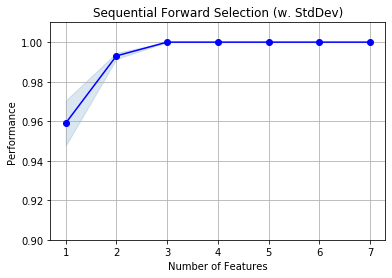

In [59]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.data import wine_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

index, num_pair = fisher_index(pvalue_fdr2,0.001)

etc_train = extract(x_train,index,'rank')
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
etc_train_resampled = extract(x_resampled,index,'rank')
# x_1, x_t, y_1, y_t = train_test_split(etc_train_resampled, y_resampled, test_size=0.33, random_state=7)

knn = KNeighborsClassifier(n_neighbors=2)
# lgr = LogisticRegression()
# mlp = MLPClassifier(hidden_layer_sizes=(5,),max_iter=1000,alpha=0.1,learning_rate='adaptive', random_state=2)

sfs1 = SFS(estimator=knn, 
           k_features=(1, 7),
           forward=True, 
           floating=True, 
           scoring='roc_auc',
           cv=5)

# pipe = make_pipeline(StandardScaler(), sfs1)

sfs1.fit(etc_train_resampled, y_resampled)

print('best combination (AUC: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))
print('all subsets:\n', sfs1.subsets_)
# plot_sfs(sfs1.get_metric_dict(), kind='std_err')

fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

plt.ylim([0.90, 1.01])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.savefig('MLPfeature_selection.png',dpi=600)
plt.show()

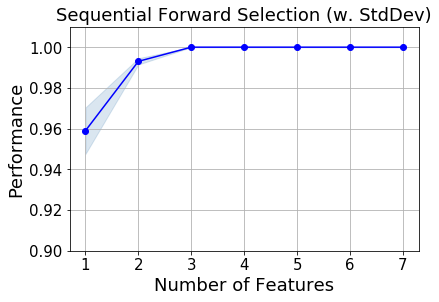

In [60]:
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
parameters = {'axes.labelsize': 18,
              'axes.titlesize': 18}
plt.rcParams.update(parameters)
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

plt.ylim([0.90, 1.01])
plt.title('Sequential Forward Selection (w. StdDev)',fontsize=18)
plt.grid()
plt.tight_layout(pad=0)
plt.savefig('MLPfeature_selection.svg',dpi=600)

In [61]:
index, num_pair = fisher_index(pvalue_fdr2,0.001)
pairidx = index[:,sfs1.k_feature_idx_]
print(comidx[pairidx[0]])
print(comidx[pairidx[1]])

pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52
Index(['BIRC5', 'PTK2B', 'S100A14'], dtype='object')
Index(['PRKCQ', 'OGN', 'NR2F1'], dtype='object')


# Rank + Other Classifier

In [62]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

In [63]:
names = ["RankLasso", "RankNeural Net","RankLogistic Regression","Nearest Neighbors", "Linear SVM", 
         "RBF SVM","Gaussian Process","Decision Tree", "Random Forest", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    linear_model.LassoCV(max_iter=1000,cv=5,random_state=5),
    MLPClassifier(hidden_layer_sizes=(20,20),alpha=0.1, max_iter=1000,learning_rate='adaptive', random_state=2),
    LogisticRegression(),
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025,random_state=7),
    SVC(gamma=2, C=1,random_state=7),
    GaussianProcessClassifier(1.0 * RBF(1.0),random_state=7),
    DecisionTreeClassifier(random_state=7),
    RandomForestClassifier(random_state=7),
    AdaBoostClassifier(random_state=7),
    GaussianNB()]

# Main

In [64]:
def trainmodel(x,y):
    for name,clf_ in zip (names, classifiers):
        clf_.fit(etc_train_resampled, y_resampled)
        if name == 'RankLasso':
            print ("num_lasso_pair = ", np.sum(clf_.coef_!=0))

In [65]:
def testmodel(x_test,y_test,index,tn):
    testrsl = []
    testrsl.append(tn)
    testrsl.append(num_pair)
    testrsl.append(len(np.union1d(index[0],index[1])))
    
    rankauc = metrics.roc_auc_score(y_test, test_rank(x_test,y_test,index))
    testrsl.append('%.3f' % rankauc)

    etc_test = extract(x_test,index,typ)
    for name, clf_ in zip(names, classifiers):
        predt = clf_.predict(etc_test)
        print (name, "test ROC AUC: ",metrics.roc_auc_score(y_test, predt))
        testrsl.append('%.3f' % metrics.roc_auc_score(y_test, predt))
#         testrsl.append('%.3f' % average_precision_score(y_test, predt))
        
    return testrsl

In [66]:
# pvalue_thresholds = np.arange(3e-5,6e-5,1e-5)
# thresholds = [1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14]
thresholds = [0.001]
thre_type = 'fdr'
# thresholds = [0.9,0.88,0.87,0.86,0.84,0.83,0.82,0.81,0.80,0.79,0.78,0.77,0.76]
# thre_type = 'rev'
typ = 'rank'
rows = []
finalrsl = []
x_test = [x_train1,x_train2,x_test4,x_test1,x_test2,x_test3]
y_test = [y_train1,y_train2,y_test4,y_test1,y_test2,y_test3]
testname = ["train1TCGA","train2GEO","own data","test1GEO","test2GEO","test3TCGA"]

for threshold in thresholds:
    if thre_type == 'fdr':
        finalrsl.append(['fdr<'+'%.0e' % threshold])
    else:
        finalrsl.append(['rev>'+'%.2f' % threshold])
    
#     index, num_pair = rev_index(a,b,c,d,threshold)
    index, num_pair = fisher_index(pvalue_fdr2,threshold)
    index = index[:,[1, 17, 42]]
    x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
    etc_train_resampled = extract(x_resampled,index,'rank')
    
    trainmodel(etc_train_resampled, y_resampled)
        
    for x_, y_, tn in zip(x_test,y_test,testname):
        finalrsl.append(testmodel(x_,y_,index,tn))

pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52
num_lasso_pair =  3
RankLasso test ROC AUC:  1.0
RankNeural Net test ROC AUC:  1.0
RankLogistic Regression test ROC AUC:  0.9931623931623932
Nearest Neighbors test ROC AUC:  1.0
Linear SVM test ROC AUC:  0.9931623931623932
RBF SVM test ROC AUC:  1.0
Gaussian Process test ROC AUC:  1.0
Decision Tree test ROC AUC:  1.0
Random Forest test ROC AUC:  1.0
AdaBoost test ROC AUC:  1.0
Naive Bayes test ROC AUC:  1.0
RankLasso test ROC AUC:  1.0
RankNeural Net test ROC AUC:  1.0
RankLogistic Regression test ROC AUC:  0.9905660377358491
Nearest Neighbors test ROC AUC:  1.0
Linear SVM test ROC AUC:  0.9905660377358491
RBF SVM test ROC AUC:  1.0
Gaussian Process test ROC AUC:  1.0
Decision Tree test ROC AUC:  1.0
Random Forest test ROC AUC:  1.0
AdaBoost test ROC AUC:  1.0
Naive Bayes test ROC AUC:  1.0
RankLasso test ROC AUC:  1.0
RankNeural Net test ROC AUC:  1.0
RankLogistic Regression test ROC AUC:  0.9375
Nearest Neighb

# Set field name of the result

In [67]:
fields = ['','num_pair','num_gene','rank_test']
for name in names:
    fields.append(name)

print (fields)

['', 'num_pair', 'num_gene', 'rank_test', 'RankLasso', 'RankNeural Net', 'RankLogistic Regression', 'Nearest Neighbors', 'Linear SVM', 'RBF SVM', 'Gaussian Process', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Naive Bayes']


# Write into csv

In [68]:
import csv
from datetime import datetime

dateTimeObj = datetime.now()
timestr = dateTimeObj.strftime('%m%dT%H')
# # 属性名称
# fields = ['Name', 'Goals', 'Assists', 'Shots']

# # csv文件中每一行的数据，一行为一个列表
# rows = [ ['Emily', '12', '18', '112'],
# ['Katie', '8', '24', '96'],
# ['John', '16', '9', '101'],
# ['Mike', '3', '14', '82']]

# filename = "./Result/2pairs_prc_diff1_mlpsfs_0728.csv"
filename = "./Result/diff0.5.csv"


# 将数据写入到csv文件中
with open(filename, 'w+') as csvfile:
    # 创建一个csv writer对象
    csvwriter = csv.writer(csvfile)
    # 写入属性名称
    csvwriter.writerow(fields)
    # 写入数据
    csvwriter.writerows(finalrsl)

# Plot

pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52


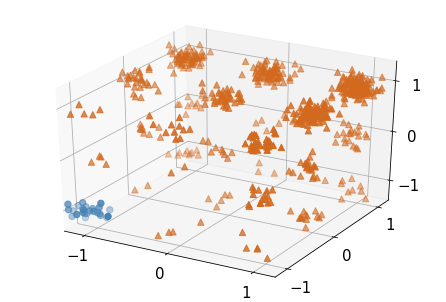

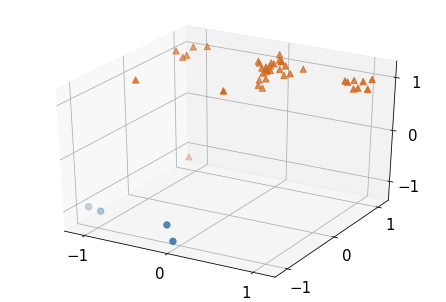

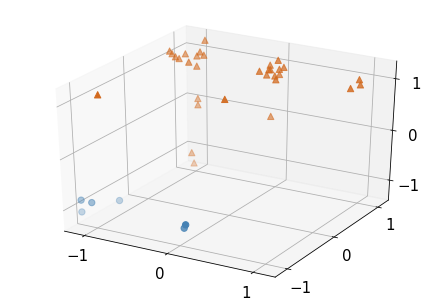

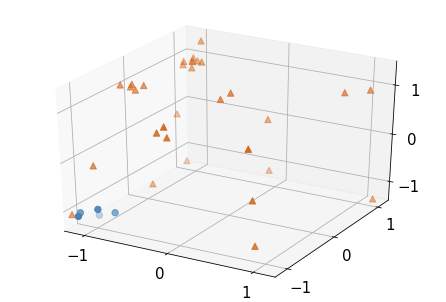

In [69]:
index, num_pair = fisher_index(pvalue_fdr2,0.001)
pairidx = index[:,[1,17,42]]
# x_test = [x_train1,x_train2, x_test4, x_test1,x_test2,x_test3]
# y_test = [y_train1,y_train2, y_test4, y_test1,y_test2,y_test3]
# testname = ["train1","train2","validation","test1GEO","test2GEO","test3TCGA"]
x_test = [x_train, x_test1,x_test2,x_test3]
y_test = [y_train, y_test1,y_test2,y_test3]
testname = ["train","test1GEO","test2GEO","test3TCGA"]

for x_,y_,ds in zip(x_test,y_test,testname):
    etc_x = extract(x_,pairidx,'rank')
    rand1 = np.random.randn(1,len(etc_x[:,0]))*0.1-0.05
    rand2 = np.random.randn(1,len(etc_x[:,0]))*0.1-0.05
    rand3 = np.random.randn(1,len(etc_x[:,0]))*0.1-0.05
    pt_df = pd.DataFrame( {'pair 1':np.squeeze(etc_x[:,0]+rand1),
                           'pair 2':np.squeeze(etc_x[:,1]+rand2),
                           'pair 3':np.squeeze(etc_x[:,2]+rand3),
                           'label':y_}, 
                         columns = ['pair 1','pair 2','pair 3','label'])
#     pt_df.replace(to_replace={'label':1}, value='case', inplace=True)
#     pt_df.replace(to_replace={'label':0}, value='control', inplace=True)

    plt.figure()
    ax = plt.axes(projection="3d")
    pt_df0 = pt_df[pt_df['label']==0]
    pt_df1 = pt_df[pt_df['label']==1]
#     plt.zlim(-1, 1)
    ax.scatter3D(pt_df1['pair 1'], pt_df1['pair 2'], pt_df1['pair 3'],c= 'chocolate', marker = '^',s=40)
    ax.scatter3D(pt_df0['pair 1'], pt_df0['pair 2'], pt_df0['pair 3'],c= 'steelblue',marker = 'o',s=40)
    plt.xlim(-1.2, 1.2)
    ax.set_xticks([-1, 0, 1])
    plt.ylim(-1.2, 1.2)
    ax.set_yticks([-1, 0, 1])
    ax.set_zticks([-1, 0, 1])
    plt.tight_layout(pad=0)
    plt.savefig('./pairplot/'+ds+'scatterplot.png',dpi=300)
    plt.show()

In [70]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

clf = linear_model.LassoCV(max_iter=1000,cv=5,random_state=5)
index, num_pair = fisher_index(pvalue_fdr2,0.001)
index = index[:,[1,17,42]]
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
etc_train_resampled = extract(x_resampled,index,'rank')

clf.fit(etc_train_resampled, y_resampled)

x_test = [x_train, x_test1,x_test2,x_test3]
y_test = [y_train, y_test1,y_test2,y_test3]
testname = ["train","test1GEO","test2GEO","test3TCGA"]

for x_,y_,ds in zip(x_test,y_test,testname):
    etc_train = extract(x_,index,'rank')
    pred = clf.predict(etc_train)>0.3
    
    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_, pred).ravel()
    print(ds,'\ntp, fp, fn, tn:')
    print(tp, fp, fn, tn)
    
    # Accuracy
    print('accuracy:',accuracy_score(y_, pred))
    
    # Recall
    print('sensitivity:',tp / (tp + fn))
    
    # Sepcificity
    print('sepcificity:',tn / (tn + fp),'\n')

pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52
train 
tp, fp, fn, tn:
640 0 6 26
accuracy: 0.9910714285714286
sensitivity: 0.9907120743034056
sepcificity: 1.0 

test1GEO 
tp, fp, fn, tn:
41 0 0 4
accuracy: 1.0
sensitivity: 1.0
sepcificity: 1.0 

test2GEO 
tp, fp, fn, tn:
32 0 0 6
accuracy: 1.0
sensitivity: 1.0
sepcificity: 1.0 

test3TCGA 
tp, fp, fn, tn:
30 0 2 5
accuracy: 0.9459459459459459
sensitivity: 0.9375
sepcificity: 1.0 



pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52
[0. 0. 1.] [0.         0.67801858 1.        ]
[0. 0. 1.] [0.         0.79256966 1.        ]
[0. 0. 1.] [0.         0.85603715 1.        ]


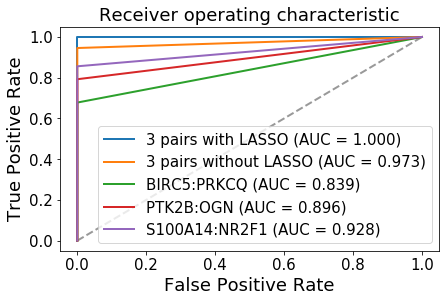

In [71]:
# AUC of train
clf = linear_model.LassoCV(max_iter=1000,cv=5,random_state=5)
index, num_pair = fisher_index(pvalue_fdr2,0.001)
index = index[:,[1,17,42]]
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
plt.figure()

etc_train_resampled = extract(x_resampled,index,'rank')
clf.fit(etc_train_resampled, y_resampled)
etc_train = extract(x_train,index,'rank')
pred = clf.predict(etc_train)
fpr, tpr, _ = metrics.roc_curve(y_train, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='3 pairs with LASSO (AUC = {0:0.3f})'.format(roc_auc), linewidth=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2,color='gray', alpha=.8)

pred = test_rank(x_train,y_train,index)
fpr, tpr, _ = metrics.roc_curve(y_train, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='3 pairs without LASSO (AUC = {0:0.3f})'.format(roc_auc), linewidth=2)

for i in range(0,3):
#     pred = extract(x_train,index[:,[i]],'rank')
    pred = extract2(x_train,index[:,[i]])
    fpr, tpr, _ = metrics.roc_curve(y_train, pred)
    roc_auc = metrics.auc(fpr, tpr)
    print(fpr,tpr)
    plt.plot(fpr, tpr, label='{0}:{1} (AUC = {2:0.3f})'.format(df4.index[index[0,i]],
                                                              df4.index[index[1,i]],roc_auc), linewidth=2)

# for i in range(0,3):
#     etc_train_resampled = extract(x_resampled,np.delete(index,i,axis=1),'rank')
#     clf.fit(etc_train_resampled, y_resampled)
#     etc_train = extract(x_train,np.delete(index,i,axis=1),'rank')
#     pred = clf.predict(etc_train)
#     fpr, tpr, _ = metrics.roc_curve(y_train, pred)
#     roc_auc = metrics.auc(fpr, tpr)
#     plt.plot(fpr, tpr, label='AUC = {0:0.3f})'.format(roc_auc), linewidth=2)

# plt.xlim(-0.1, 0.2)
# plt.ylim(0.8, 1.1)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right", fontsize=15)
plt.tight_layout(pad=0)
plt.savefig('./pairplot/train_auc.png',dpi=300)
plt.show()

pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52


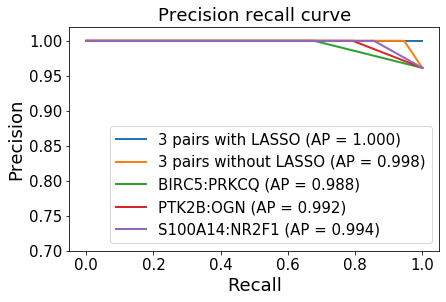

In [72]:
# PRC of train
clf = linear_model.LassoCV(max_iter=1000,cv=5,random_state=5)
index, num_pair = fisher_index(pvalue_fdr2,0.001)
index = index[:,[1,17,42]]
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
plt.figure()

etc_train_resampled = extract(x_resampled,index,'rank')
clf.fit(etc_train_resampled, y_resampled)
etc_train = extract(x_train,index,'rank')
pred = clf.predict(etc_train)
pre, rec, _ = metrics.precision_recall_curve(y_train, pred)
prc = metrics.average_precision_score(y_train, pred)
# plt.step(rec, pre, where='post',label='3 pairs with weights (AP = {0:0.3f})'.format(prc), linewidth=2)
plt.plot(rec, pre,label='3 pairs with LASSO (AP = {0:0.3f})'.format(prc), linewidth=2)

pred = test_rank(x_train,y_train,index)
pre, rec, _ = metrics.precision_recall_curve(y_train, pred)
prc = metrics.average_precision_score(y_train, pred)
# plt.step(rec, pre, where='post', label='3 pairs without weights (AP = {0:0.3f})'.format(prc), linewidth=2)
plt.plot(rec, pre, label='3 pairs without LASSO (AP = {0:0.3f})'.format(prc), linewidth=2)



for i in range(0,3):
#     pred = extract(x_train,index[:,[i]],'rank')
    pred = extract2(x_train,index[:,[i]])
    pre, rec, _ = metrics.precision_recall_curve(y_train, pred)
    prc = metrics.average_precision_score(y_train, pred)
    plt.plot(rec, pre, label='{0}:{1} (AP = {2:0.3f})'.format(df4.index[index[0,i]],
                                                              df4.index[index[1,i]],prc), linewidth=2)

# plt.xlim(-0.1, 0.2)
plt.ylim(0.7, 1.02)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision recall curve', fontsize=18)
plt.legend(loc="lower right", fontsize=15)
plt.tight_layout(pad=0)
plt.savefig('./pairplot/train_prc.png',dpi=300)
plt.show()

pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52
[0.   0.25 1.  ] [0.         0.53658537 1.        ]
[0. 0. 1.] [0. 1. 1.]
[0. 0. 1.] [0.         0.97560976 1.        ]


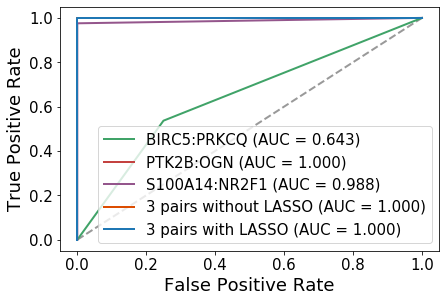

[0. 0. 1.] [0.      0.15625 1.     ]
[0. 0. 1.] [0.      0.96875 1.     ]
[0. 0. 1.] [0.    0.875 1.   ]


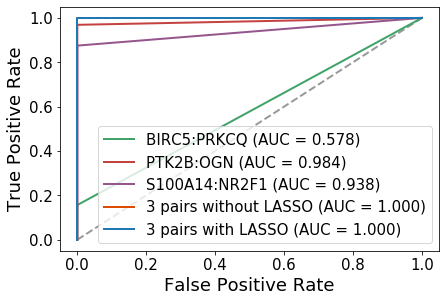

[0. 0. 1.] [0.     0.3125 1.    ]
[0. 0. 1.] [0.      0.59375 1.     ]
[0. 0. 1.] [0.      0.78125 1.     ]


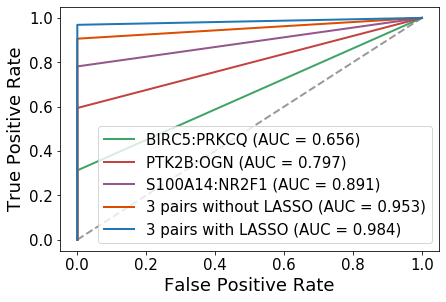

In [73]:
# AUC of test
clf = linear_model.LassoCV(max_iter=1000,cv=5,random_state=5)
index, num_pair = fisher_index(pvalue_fdr2,0.001)
index = index[:,[1,17,42]]
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
etc_train_resampled = extract(x_resampled,index,'rank')
clf.fit(etc_train_resampled, y_resampled)

x_test = [x_test1,x_test2,x_test3]
y_test = [y_test1,y_test2,y_test3]
testname = ["test1GEO","test2GEO","test3TCGA"]
colors = [sns.xkcd_rgb['greenish'],sns.xkcd_rgb['reddish'],sns.xkcd_rgb['purplish']]

for x_,y_,ds in zip(x_test,y_test,testname):
    plt.rc('xtick', labelsize=15)     
    plt.rc('ytick', labelsize=15)
    plt.figure()

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2,color='gray', alpha=.8)
    
    for i,c in zip(range(0,3),colors):
        pred = extract2(x_,index[:,[i]])
        fpr, tpr, _ = metrics.roc_curve(y_, pred)
        roc_auc = metrics.auc(fpr, tpr)
        print(fpr,tpr)
        plt.plot(fpr, tpr, label='{0}:{1} (AUC = {2:0.3f})'.format(df4.index[index[0,i]],
                                                              df4.index[index[1,i]],roc_auc), linewidth=2,c=c)
    
    pred = test_rank(x_,y_,index)
    fpr, tpr, _ = metrics.roc_curve(y_, pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label='3 pairs without LASSO (AUC = {0:0.3f})'.format(roc_auc), linewidth=2, c=sns.xkcd_rgb['deep orange'])

        
    etc_ = extract(x_,index,'rank')
    pred = clf.predict(etc_)
    fpr, tpr, _ = metrics.roc_curve(y_, pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label='3 pairs with LASSO (AUC = {0:0.3f})'.format(roc_auc), linewidth=2)
    
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    # plt.title('Receiver operating characteristic', fontsize=18)
    plt.legend(loc="lower right", fontsize=15)
    plt.tight_layout(pad=0)
    plt.savefig('./pairplot/'+ds+'_auc.png',dpi=300)
    plt.show()

pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52


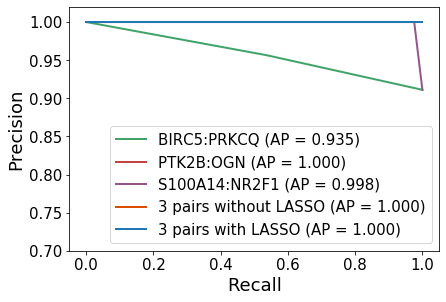

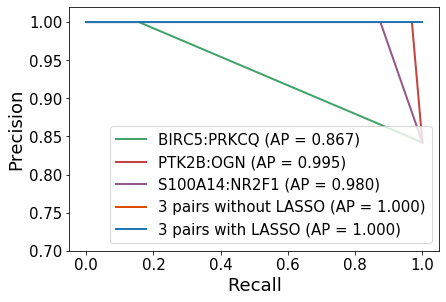

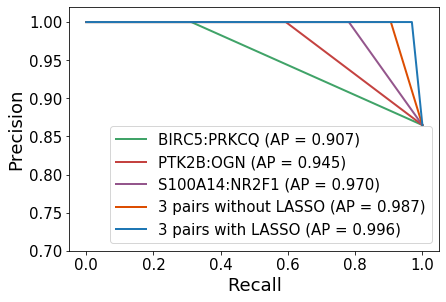

In [74]:
# AUC of test
clf = linear_model.LassoCV(max_iter=1000,cv=5,random_state=5)
index, num_pair = fisher_index(pvalue_fdr2,0.001)
index = index[:,[1,17,42]]
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
etc_train_resampled = extract(x_resampled,index,'rank')
clf.fit(etc_train_resampled, y_resampled)

x_test = [x_test1,x_test2,x_test3]
y_test = [y_test1,y_test2,y_test3]
testname = ["test1GEO","test2GEO","test3TCGA"]
colors = [sns.xkcd_rgb['greenish'],sns.xkcd_rgb['reddish'],sns.xkcd_rgb['purplish']]

for x_,y_,ds in zip(x_test,y_test,testname):
    plt.rc('xtick', labelsize=15)     
    plt.rc('ytick', labelsize=15)
    plt.figure()
    
    for i,c in zip(range(0,3),colors):
        pred = extract2(x_,index[:,[i]])
        pre, rec, _ = metrics.precision_recall_curve(y_, pred)
        prc = metrics.average_precision_score(y_, pred)
        plt.plot(rec, pre, label='{0}:{1} (AP = {2:0.3f})'.format(df4.index[index[0,i]],
                                                              df4.index[index[1,i]],prc), linewidth=2,c=c)

    
    pred = test_rank(x_,y_,index)
    pre, rec, _ = metrics.precision_recall_curve(y_, pred)
    prc = metrics.average_precision_score(y_, pred)
    plt.plot(rec, pre, label='3 pairs without LASSO (AP = {0:0.3f})'.format(prc), linewidth=2, c=sns.xkcd_rgb['deep orange'])

        
    etc_ = extract(x_,index,'rank')
    pred = clf.predict(etc_)
    pre, rec, _ = metrics.precision_recall_curve(y_, pred)
    prc = metrics.average_precision_score(y_, pred)
    plt.plot(rec, pre, label='3 pairs with LASSO (AP = {0:0.3f})'.format(prc), linewidth=2)
    
    plt.ylim(0.7, 1.02)
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    # plt.title('Precision recall curve', fontsize=18)
    plt.legend(loc="lower right", fontsize=15)
    plt.tight_layout(pad=0)
    plt.savefig('./pairplot/'+ds+'_ap.png',dpi=300)
    plt.show()

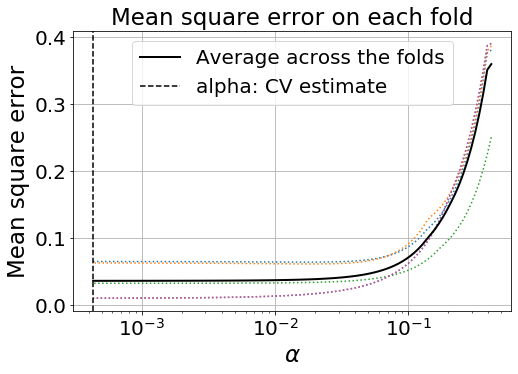

In [75]:
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
etc_train_resampled = extract(x_resampled,index,'rank')
model = linear_model.LassoCV(cv=5,random_state=5,normalize=False).fit(etc_train_resampled,y_resampled)


#############################################################################
# LassoCV: coordinate descent
EPSILON = 1e-5
m_log_alphas = -np.log10(model.alphas_ + EPSILON)

plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)
plt.figure(figsize=(7,5))
# ymin, ymax = 0, 0.6
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ':')
plt.plot(model.alphas_ + EPSILON, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_ + EPSILON, linestyle='--', color='k',
            label='alpha: CV estimate')
plt.legend(fontsize=20)

plt.xlabel(r'$\alpha$',fontsize=23)
plt.ylabel('Mean square error',fontsize=23)
plt.title('Mean square error on each fold',fontsize=23)
plt.axis('tight')
plt.grid()
plt.tight_layout(pad=0)
plt.savefig('./lassotrain.png',dpi=300)

In [76]:
print(model.alpha_)
print(model.coef_)
print(model.intercept_)

0.0004198916408668732
[0.15397104 0.1787139  0.2484305 ]
0.6446589978983183


In [77]:

# colors = sns.xkcd_rgb['denim blue','greenish','reddish','purplish']
# colors

# PCA

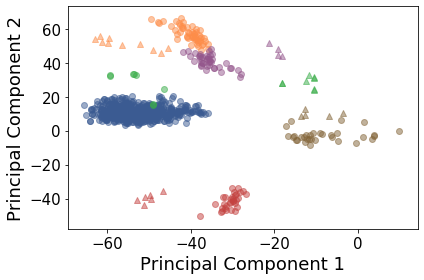

In [78]:
from mlxtend.feature_extraction import PrincipalComponentAnalysis


colors = [sns.xkcd_rgb['denim blue'],sns.xkcd_rgb['orangeish'],sns.xkcd_rgb['medium green'],
         sns.xkcd_rgb['purplish'],sns.xkcd_rgb['reddish'],sns.xkcd_rgb['dirt brown']]
x_test = [x_train1,x_train2,x_test4,x_test1,x_test2,x_test3]
y_test = [y_train1,y_train2,y_test4,y_test1,y_test2,y_test3]
testname = ["TCGA","GSE18520","Ours","test1GEO","test2GEO","test3TCGA"]

plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
# plt.figure(figsize=(6, 4))
plt.figure()
legs = ['control','case']

for X,y,ds,col in zip(x_test,y_test,testname,colors):
    pca = PrincipalComponentAnalysis(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)

    for lab, mak,leg in zip((0, 1),('^', 'o'),legs):
        plt.scatter(X_pca[y==lab, 0],
                    X_pca[y==lab, 1],
                    label=ds,
                    marker=mak,
                    c=col,
                   alpha = 1/2)
plt.xlabel('Principal Component 1', fontsize=18)
plt.ylabel('Principal Component 2', fontsize=18)
# plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.tight_layout()
plt.show()

In [79]:
dfcom = pd.read_csv('./ocRMA/ov.combat.txt',sep = "\t", index_col=0,header = 0)
labcom = np.genfromtxt('./oclabel/ov.allabel.txt',dtype="u1,U16,u1,u1")['f3']

# x_com = dfcom.to_numpy().T
# y_com = labcom

# Prognosis

pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52
[0.15403749 0.17883503 0.24830525] 0.6446972963268187
>1.1:  128
<1.1:  455


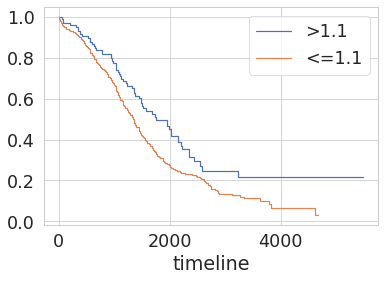

In [102]:
import kaplanmeier as km
import pandas as pd
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter

df_tcga = pd.read_csv('./ocRMA/HTHG584survival.txt',sep = "\t", index_col=0,header = 0)
lab = pd.read_csv('./oclabel/tcga584survival.txt',sep = "\t", index_col=1,header=0)
lab = lab[['OS.time','OS']]
lab = lab.drop(index='TCGA.36.2533.01')
df_tcga = df_tcga.drop(columns='TCGA.36.2533.01')

df_tcga = df_tcga.loc[comidx]
x_ = df_tcga.to_numpy().T

typ = 'rank'
index1, num_pair = fisher_index(pvalue_fdr2,0.001)
pairidx = index1[:,[1, 17, 42]]

x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
etc_train_resampled = extract(x_resampled,pairidx,'rank')
model = linear_model.LassoCV(cv=5,random_state=5,normalize=True).fit(etc_train_resampled,y_resampled)
print (model.coef_, model.intercept_)

etc_x = extract(x_,pairidx,'rank')
pdt = model.predict(etc_x)
# print(pdt)

# for i in [0.3,0.4,0.61, 0.69, 0.84, 0.92]:
for i in [1.1]:
    ix1 = (pdt > i)
    print(">1.1: ", sum(ix1))
    ix0 = (pdt <= i)
    print("<1.1: ", sum(ix0))
    kmf = KaplanMeierFitter()
    kmf.fit(lab['OS.time'][ix1], event_observed=lab['OS'][ix1], label='>{}'.format(i))
    ax = kmf.plot(ci_show=False)
    kmf.fit(lab['OS.time'][ix0], event_observed=lab['OS'][ix0], label='<={}'.format(i))
    ax = kmf.plot(ax=ax,ci_show=False)
    plt.show()
    
    #logrank_test
    results=logrank_test(lab['OS.time'][ix1],lab['OS.time'][ix0],event_observed_A=lab['OS'][ix1], event_observed_B=lab['OS'][ix0])
    results.print_summary()

In [81]:
df_tcga.columns == 'TCGA.04.1331.01'
pdt[df_tcga.columns == 'TCGA.04.1331.01']

array([1.04704004])

In [82]:
df_tcga.columns[pdt >= 1.2258750]

Index(['TCGA.61.1910.01', 'TCGA.13.1819.02', 'TCGA.13.1819.01',
       'TCGA.24.2281.01', 'TCGA.13.0791.02', 'TCGA.13.1506.01',
       'TCGA.23.1119.01', 'TCGA.13.1489.02', 'TCGA.24.1564.01',
       'TCGA.23.2081.01',
       ...
       'TCGA.13.0761.01', 'TCGA.25.1878.01', 'TCGA.29.2432.01',
       'TCGA.13.0911.01', 'TCGA.23.1110.01', 'TCGA.24.1464.01',
       'TCGA.23.2649.01', 'TCGA.29.1707.02', 'TCGA.61.1907.01',
       'TCGA.36.2547.01'],
      dtype='object', length=128)

In [83]:
np.unique(pdt)

array([0.21755702, 0.24235455, 0.31182478, 0.37159451, 0.39639204,
       0.42118958, 0.46586227, 0.49065981, 0.55042954, 0.56013003,
       0.57522707, 0.61989976, 0.6446973 , 0.66949483, 0.71416752,
       0.72926456, 0.73896506, 0.79873479, 0.82353233, 0.86820501,
       0.89300255, 0.91780009, 0.97756982, 1.04704004, 1.07183758,
       1.22587507])

In [84]:
df_stage = pd.read_csv("./ocRMA/SS2.txt",sep=" ",index_col = None)
df_stage

,V1,V2,V3,V4,stage
1,TCGA.61.1910.01,1,1,1,stage1
2,TCGA.61.1728.01,1,0,1,stage2
3,TCGA.13.1819.02,1,1,1,stage1
4,TCGA.31.1953.01,-1,1,1,stage2
5,TCGA.13.1819.01,1,1,1,stage1
...,...,...,...,...,...
576,TCGA.61.2094.01,1,1,0,stage2
577,TCGA.25.1628.01,0,0,0,stage2
578,TCGA.04.1371.01,1,0,0,stage2
579,TCGA.29.1707.02,1,1,1,stage2


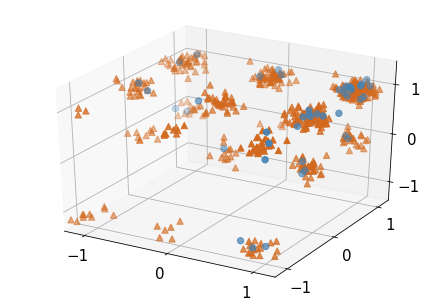

In [85]:
df_stage = pd.read_csv("./ocRMA/SS2.txt",sep=" ")

rand1 = np.random.randn(1,580)*0.1-0.05
rand2 = np.random.randn(1,580)*0.1-0.05
rand3 = np.random.randn(1,580)*0.1-0.05

df_stage['V2']=df_stage['V2'].add(rand1.squeeze())
df_stage['V3']=df_stage['V3'].add(rand2.squeeze())
df_stage['V4']=df_stage['V4'].add(rand3.squeeze())

plt.figure()
ax = plt.axes(projection="3d")
pt_df0 = df_stage[df_stage['stage']=="stage1"]
pt_df1 = df_stage[df_stage['stage']=="stage2"]


ax.scatter3D(pt_df0['V2'], pt_df0['V3'], pt_df0['V4'],c= 'steelblue',marker = 'o',s=40)
ax.scatter3D(pt_df1['V2'], pt_df1['V3'], pt_df1['V4'],c= 'chocolate', marker = '^',s=40)

plt.xlim(-1.2, 1.2)
ax.set_xticks([-1, 0, 1])
plt.ylim(-1.2, 1.2)
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-1, 0, 1])
plt.tight_layout(pad=0)
# plt.savefig('./pairplot/'+ds+'scatterplot.png',dpi=300)
plt.show()

In [86]:
df_stage['V2']=df_stage['V2'].add(rand1.squeeze())

# Validated on blood

In [87]:
df8 = pd.read_csv('./ocRMA/blood/GSE11545.txt',sep = "\t", index_col=0,header = 0)
lab8 = np.genfromtxt('./oclabel/blood/GSE11545.label.txt',dtype="U16,U16,u1")['f2']
df9 = pd.read_csv('./ocRMA/blood/GSE31682.txt',sep = "\t", index_col=0,header = 0)
lab9 = np.genfromtxt('./oclabel/blood/GSE31682.label.txt',dtype="U16,U16,u1,u1")['f3']
df10 = pd.read_csv('./ocRMA/blood/GSE37582.txt',sep = "\t", index_col=0,header = 0)
lab10 = np.genfromtxt('./oclabel/blood/GSE37582.label.txt',dtype="U16,U16,u1")['f2']

In [88]:
index, num_pair = fisher_index(pvalue_fdr2,0.001)
pairidx = index[:,[1,17,42]]

def df_pair(df,idx):
    sub1 = df.loc[comidx[idx[0]]].values - df.loc[comidx[idx[1]]].values > diff
    sub2 = -1*(df.loc[comidx[idx[0]]].values - df.loc[comidx[idx[1]]].values < -diff)
#     sub1 = df.loc['PRKCD'].values - df.loc['CFD'].values > diff
#     sub2 = -1*(df.loc['PRKCD'].values - df.loc['CFD'].values < -diff)
    sub = sub1+sub2
    return sub


# x_test9[comidx[pairidx[1][3]]]

# print(comidx[pairidx[1][0]])

# x_test8 = df_pair(df8,pairidx)
# x_test9 = df_pair(df9,pairidx)
x_test10 = df_pair(df10,pairidx)

x_test10.T

pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52


array([[-1,  1,  0],
       [-1,  1, -1],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0],
       [-1,  

# Print out the name of gene pair
datanote = np.genfromtxt('./data/GSE8121lncRNA.txt',dtype='str', skip_header=1,usecols=(0))
for i in range(0,22):
    print datanote[index0[i]], datanote[index1[i]]

In [89]:
typ = 'rank'
index1, num_pair = fisher_index(pvalue_fdr2,0.001)
pairidx = index1[:,[1, 17, 42]]
print(pairidx)

pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52
[[ 78 141 205]
 [ 48  86 181]]


In [90]:
for i in range(0,len(pairidx[0])):
    print(df4.index[pairidx[0,i]],",",df4.index[pairidx[1,i]],",",pvalue_fdr2[pairidx[0,i],pairidx[1,i]])

BIRC5 , PRKCQ , 6.416389666932327e-13
PTK2B , OGN , 1.6720794946405452e-16
S100A14 , NR2F1 , 1.4623254486810468e-22


In [91]:
idx1, num_pair = fisher_index(pvalue_fdr2,0.001)
f = open('./52pairPvalue','a')
for i in range(0,52):
    f.write(df4.index[idx1[0,i]]+","+df4.index[idx1[1,i]]+","+"{}\n".format(pvalue_fdr2[idx1[0,i],idx1[1,i]]))
f.close()

pvalue_Bonf_threshold =  0.001
number of pairs =  52
number of genes =  52


In [92]:
# index1 = np.array([[461, 567],[131, 435]])
for i in range(0,len(pairidx[0])):
    index2 = np.delete(pairidx,i,1)
    x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
    etc_train_resampled = extract(x_resampled,index2,'rank')
    model = linear_model.LassoCV(cv=5,random_state=5,normalize=True).fit(etc_train_resampled,y_resampled)
    etc_test = extract(x_test1,index2,'rank')
    auc = metrics.roc_auc_score(y_test1, model.predict(etc_test))
    print('leave pair:',i,', auc = ',auc)

leave pair: 0 , auc =  1.0
leave pair: 1 , auc =  0.9817073170731707
leave pair: 2 , auc =  1.0


In [93]:
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
etc_train_resampled = extract(x_resampled,pairidx,'rank')
model = linear_model.LassoCV(cv=5,random_state=5,normalize=True).fit(etc_train_resampled,y_resampled)

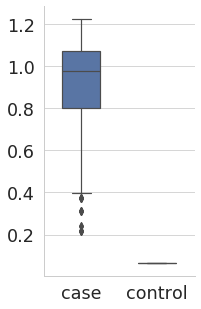

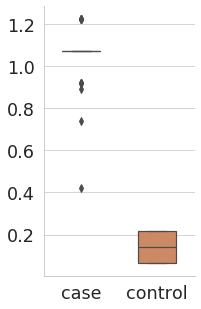

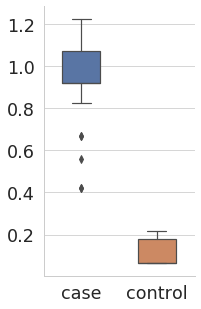

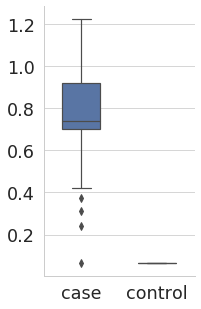

In [94]:
x_test = [x_train, x_test1,x_test2,x_test3]
y_test = [y_train, y_test1,y_test2,y_test3]
testname = ["train","test1GEO","test2GEO","test3TCGA"]

for x_,y_,ds in zip(x_test,y_test,testname):
    etc_x = extract(x_,pairidx,'rank')
    pdt = model.predict(etc_x)
    pdt_df = pd.DataFrame( {'expression level':pdt,'label':y_}, columns = ['expression level','label'])
    pdt_df.replace(to_replace={'label':1}, value='case', inplace=True)
    pdt_df.replace(to_replace={'label':0}, value='control', inplace=True)
    
    sns.set(context='paper',style='whitegrid',font_scale=2, palette='deep')
    g = sns.catplot(x='label', y='expression level', kind='box',order=['case','control'],
                    data=pdt_df, width=0.5, aspect=0.7)
    g.set(xlabel=None,ylabel=None)

#     plt.savefig('./pairplot/'+ds+'lasso'+'.png',dpi=300)
#     pdt_df.to_csv('./expression_data/pair_expression'+ds+'lasso.txt', sep='\t')
    
#     for i in range(0,len(pairidx[0])):
#         pt_df0 = pd.DataFrame( {'expression level':x_[:,pairidx[0,i]],'label':y_}, columns = ['expression level','label'])
#         pt_df0.replace(to_replace={'label':1}, value='case', inplace=True)
#         pt_df0.replace(to_replace={'label':0}, value='control', inplace=True)
#         pt_df0.insert(2,'gene',df4.index[pairidx[0,i]])

#         pt_df1 = pd.DataFrame( {'expression level':x_[:,pairidx[1,i]],'label':y_}, columns = ['expression level','label'])
#         pt_df1.replace(to_replace={'label':1}, value='case', inplace=True)
#         pt_df1.replace(to_replace={'label':0}, value='control', inplace=True)
#         pt_df1.insert(2,'gene',df4.index[pairidx[1,i]])

#         pt_df = pd.concat([pt_df0,pt_df1], sort=False)
        
#         pt_df.to_csv('./expression_data/pair_expression'+ds+'pair'+str(i)+'.txt', sep='\t')
        
#         sns.set(context='paper',style='whitegrid',font_scale=2, palette='deep')
#         g = sns.catplot(x='label', y='expression level', kind='box', hue='gene',
#                         order=['case','control'],legend=False, data=pt_df, width=0.5, aspect=0.7)
#         g.set(xlabel=None,ylabel=None)
# #         plt.savefig('./pairplot/'+ds+'pair'+str(i)+'.png',dpi=300)

In [95]:
idx = np.union1d(index1[0],index1[1])
columns = np.append(df4.index[idx].to_numpy(),['label','dataset'])
df_ = pd.DataFrame(columns = columns)

x_test = [x_train1,x_train2,x_test1,x_test2,x_test3,x_test4]
y_test = [y_train1,y_train2,y_test1,y_test2,y_test3,y_test4]
testname = ["train1TCGA","train2GEO","test1GEO","test2GEO","test3TCGA","Validation"]

for x_,y_,ds in zip(x_test,y_test,testname):
    x_case = np.sum(x_[:,idx].T * y_, axis=1)/np.sum(y_)
    x_control = np.sum(x_[:,idx].T * (1-y_), axis=1)/np.sum(1-y_)

    dis = {}
    for i in range(0,5):
        dis[df4.index[idx[i]]] = x_case[i]
    dis['label'] = 'case'
    dis['dataset'] = ds
    df_ = df_.append(dis,ignore_index = True)

    dis = {}
    for i in range(0,5):
        dis[df4.index[idx[i]]] = x_control[i]
    dis['label'] = 'control'
    dis['dataset'] = ds
    df_ = df_.append(dis,ignore_index = True)
    
df_.to_csv('mean_expression.txt', sep='\t')

In [96]:
# index1, num_pair = fisher_index(pvalue_Bonf2,1e-12)
# etc_train1 = extract(x_train,index1,typ)
# for k in range(0,3):
#     if np.sum(etc_train1,axis = 0)[k]<=0:
#         index1[0,k],index1[1,k] = index1[1,k],index1[0,k]

# test_data = [x_train1,x_train2,x_test1,x_test2,x_test3,x_test4]
# test_label = [y_train1,y_train2,y_test1,y_test2,y_test3,y_test4]
# datasets = ["train1TCGA","train2GEO","test1GEO","test2GEO","test3TCGA","Validation"]
# co = ["purple","green","blue","pink","brown","red","royalblue","teal","orange","limegreen",
#      "magenta","yellow","grey","olive"]

# for x,y,ds in zip(test_data,test_label,datasets):

#     g_df = pd.DataFrame(columns=['pair','x','hue','mean Gene Expression Level'])
#     i = 1
#     for pair1a,pair1b in index1.T:
#         con_label = 1-y
#         gel1 = sum(x[:,pair1a] * con_label)/sum(con_label)
#         g_df = g_df.append({'pair':i,'x':1,'hue':'a','mean Gene Expression Level':gel1}
#                            ,ignore_index=True)
#         gel2 = sum(x[:,pair1b] * con_label)/sum(con_label)
#         g_df = g_df.append({'pair':i,'x':2,'hue':'b','mean Gene Expression Level':gel2}
#                           ,ignore_index=True)
#         gel3 = sum(x[:,pair1a] * y)/sum(y)
#         g_df = g_df.append({'pair':i,'x':3,'hue':'a','mean Gene Expression Level':gel3}
#                           ,ignore_index=True)
#         gel4 = sum(x[:,pair1b] * y)/sum(y)
#         g_df = g_df.append({'pair':i,'x':4,'hue':'b','mean Gene Expression Level':gel4}
#                           ,ignore_index=True)
#         i+=1
        
#     plt.figure()
#     ax = sns.scatterplot(x= 'x', y = 'mean Gene Expression Level', data = g_df,hue='hue',legend=False)
#     for i in range(1,4):
#         pts = g_df[g_df['pair']==i]
#         gel1=pts[pts['x']== 1].iloc[0,-1]
#         gel2=pts[pts['x']== 2].iloc[0,-1]
#         gel3=pts[pts['x']== 3].iloc[0,-1]
#         gel4=pts[pts['x']== 4].iloc[0,-1]
#         if (gel1-gel2)*(gel3-gel4)<0:
#             pt1 = [1,2]
#             pt2 = [pts[pts['x']== 1].iloc[0,-1],pts[pts['x']== 2].iloc[0,-1]]
#             sns.lineplot(x=pt1,y=pt2,ax=ax,color=co[i-1])
#             pt3 = [3,4]
#             pt4=[pts[pts['x']== 3].iloc[0,-1],pts[pts['x']== 4].iloc[0,-1]]
#             sns.lineplot(x=pt3,y=pt4,ax=ax,color=co[i-1])
#     plt.show(ax)

# Tune NN

In [97]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0)
# x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
# index, num_pair = fisher_index(pvalue_fdr2,0.001)
# index = index[:,[5, 13, 17, 42]]
# etc_train_resampled = extract(x_resampled,index,'rank')

# rfc = MLPClassifier(max_iter=1000,learning_rate='adaptive', random_state=2)
# parameters = {
#     "hidden_layer_sizes":[(20,20,),(10,10),(30,),(20,),(15,),(10,),(5,)],
#     "alpha":[0.5,0.1,0.05,0.01,0.001,0.0001]
# }
# from sklearn.model_selection import GridSearchCV
# cv = GridSearchCV(rfc,parameters,cv=5)
# cv.fit(etc_train_resampled,y_resampled)

In [98]:
# def display(results):
#     print('Best parameters are: {}'.format(results.best_params_))
#     print("\n")
#     mean_score = results.cv_results_['mean_test_score']
#     std_score = results.cv_results_['std_test_score']
#     params = results.cv_results_['params']
#     for mean,std,params in zip(mean_score,std_score,params):
#         print('{} + or -{} for the {}'.format(round(mean,3),round(std,3),params))
# display(cv)

In [99]:
# from mlxtend.plotting import plot_learning_curves
# from mlxtend.preprocessing import shuffle_arrays_unison

# # Loading some example data
# index, num_pair = fisher_index(pvalue_fdr2,0.001)
# index = index[:,[1, 17, 42]]
# x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
# etc_train_resampled = extract(x_resampled,index,'rank')
# x_1, x_t, y_1, y_t = train_test_split(etc_train_resampled, y_resampled, test_size=0.33, random_state=7)

# clf = linear_model.LassoCV(max_iter=1000,cv=5,random_state=5)

# plot_learning_curves(x_1, y_1, x_t, y_t, clf)
# plt.show()